In [2]:
#Класс для загрузки изображений из набора данных
import os
import cv2
import numpy as np


class SimpleDatasetLoader:
    # Method: Конструктор
    def __init__(self, preprocessors=None):
        """
        :param preprocessors: списак изображений
        """
        self.preprocessors = preprocessors

        if self.preprocessors is None:
            self.preprocessors = []

    # Method: Загрузка списка изображений для предварительной обработки
    def load(self, image_paths, verbose=-1):
        """
        :param image_paths: список изображений
        :param verbose: параметр для отбражения инф в консоле
        :return: набор данных и меток
        """
        data, labels = [], []

        for i, image_path in enumerate(image_paths):
            image = cv2.imread(image_path)
            label = image_path.split(os.path.sep)[-2]

            if self.preprocessors is not None:
                for p in self.preprocessors:
                    image = p.preprocess(image)

            data.append(image)
            labels.append(label)

            if verbose > 0 and i > 0 and (i+1) % verbose == 0:
                print('[INFO]: Processed {}/{}'.format(i+1, len(image_paths)))

        return (np.array(data), np.array(labels))

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Class Preprocessror 
class SimplePreprocessor:
    # Method: Конструктор
    def __init__(self, width, height, interpolation=cv2.INTER_AREA):
        """
        :param width: Ширина 
        :param height: Высота
        :param interpolation: интерполяция
        """
        self.width = width
        self.height = height
        self.interpolation = interpolation

    # Method: Для фиксации размера изображения
    def preprocess(self, image):
        """
        :param image: изображение
        :return: изменённое изображение
        """
        return cv2.resize(image, (self.width, self.height), interpolation=self.interpolation)

In [4]:
from imutils import paths
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from __main__ import SimplePreprocessor
from __main__ import SimpleDatasetLoader

# Получаем лист изображений
image_paths = list(paths.list_images("/content/drive/MyDrive/ColabNotebooks/data_ivx/num_rom_/train"))

# Инициализация и загрузка данных
sp = SimplePreprocessor(150, 150)
sdl = SimpleDatasetLoader(preprocessors=[sp])
(data, labels) = sdl.load(image_paths, verbose=500)


In [5]:
# Изменить форму с (3000, 150, 150, 3) на (3000, 150*150*3=3072)
data = data.reshape((data.shape[0], 67500))

# Кодируем метки
le = LabelEncoder()
labels = le.fit_transform(labels)

# Делим данные на обуч и тест
(train_x, test_x, train_y, test_y) = train_test_split(data, labels, test_size=0.15, random_state=42)

# Обучение и оценка классификатора k-NN на необработанных значениях интенсивности пикселей
model = KNeighborsClassifier(n_neighbors=3, n_jobs=1)
model.fit(train_x, train_y)
# отчет по отчности
print(classification_report(test_y, model.predict(test_x),target_names=le.classes_))

              precision    recall  f1-score   support

     train_i       0.58      1.00      0.74         7
     train_v       1.00      0.43      0.60         7
     train_x       1.00      0.75      0.86         4

    accuracy                           0.72        18
   macro avg       0.86      0.73      0.73        18
weighted avg       0.84      0.72      0.71        18



In [6]:
# прогноз на оснве алгоритма k-ближайш соседей
y_test_pred = model.predict(test_x)

N_test = test_x.shape[0]

from sklearn import metrics
print(metrics.accuracy_score(test_y, y_test_pred))
print(np.mean(test_y != y_test_pred))

0.7222222222222222
0.2777777777777778


In [7]:
kk = range(1, 30, 2)
err_train = []
err_test = []
for k in kk:
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(train_x, train_y)
    err_train.append(np.mean(model.predict(train_x) != train_y))
    err_test.append(np.mean(model.predict(test_x) != test_y))
# генерируем матрицу ошибок
metrics.confusion_matrix(test_y, y_test_pred)

array([[7, 0, 0],
       [4, 3, 0],
       [1, 0, 3]])

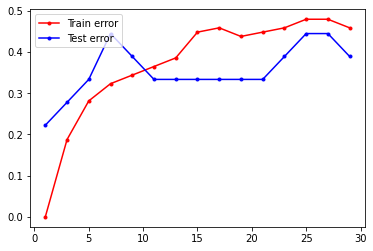

In [8]:
import matplotlib.pyplot as plt
plt.plot(kk, err_train, '.-r', label = 'Train error')
plt.plot(kk, err_test,  '.-b', label = 'Test error')    
plt.legend(loc = 2)

In [9]:
print(min(err_test))
print(kk[err_test.index(min(err_test))])

0.2222222222222222
1


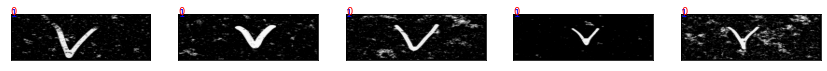

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize = (450, 450)) # Размер окна в дюймах
i_subplot = 1 
yi_test_pred =model.predict(test_x)
for i in range(12):
    if yi_test_pred[i]!= test_y[i]:
        plt.subplot(150, 150, i_subplot)
        i_subplot += 1
        plt.xticks([])
        plt.yticks([])
        plt.imshow(np.reshape(test_x[i, :], (150, -1)), cmap = plt.cm.binary)
        plt.text(0, 7, str(test_y[i]),    color = 'b')        
        plt.text(0, 1, str(yi_test_pred[i]), color = 'r')